## Income Risks Estimation 

This noteobok contains the following

 - Estimation functions of time-varying income risks for an integrated moving average process of income/earnings
 - It will allow for estimation jointly using data and expectation survey with alternative assumptions about expectations, ranging from rational expectation to alternative assumptions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
#from scipy.optimize import root
import copy as cp

In [2]:
from IncomeProcess import IMAProcess as ima

In [3]:
## debugging test of the data 

t = 66
ma_nosa = np.array([1])
p_sigmas = np.arange(t)  # sizes of the time-varying permanent volatility 
p_sigmas_rw = np.ones(t) # a special case of time-invariant permanent volatility, random walk 
p_sigmas_draw = np.random.uniform(0,1,t) ## allowing for time-variant shocks 

pt_ratio = 0.33
t_sigmas = pt_ratio * p_sigmas_draw # sizes of the time-varyingpermanent volatility
sigmas = np.array([p_sigmas_draw,
                   t_sigmas])

dt = ima(t = t,
         ma_coeffs = ma_nosa)
dt.sigmas = sigmas
sim_data = dt.SimulateSeries(n_sim = 8000)
sim_moms = dt.SimulatedMoments()

In [4]:
## get the computed moments 

comp_moms = dt.ComputeGenMoments()

av_comp = comp_moms['Mean']
cov_var_comp = comp_moms['Var']
var_comp = dt.AutocovarComp(step=0) #np.diagonal(cov_var_comp)
autovarb1_comp = dt.AutocovarComp(step=-1)  #np.array([cov_var_comp[i,i+1] for i in range(len(cov_var_comp)-1)]) 

In [5]:
## get the simulated moments 
av = sim_moms['Mean']
cov_var = sim_moms['Var']
var = dt.Autocovar(step = 0)   #= np.diagonal(cov_var)
autovarb1 = dt.Autocovar(step = -1) #np.array([cov_var[i,i+1] for i in range(len(cov_var)-1)]) 

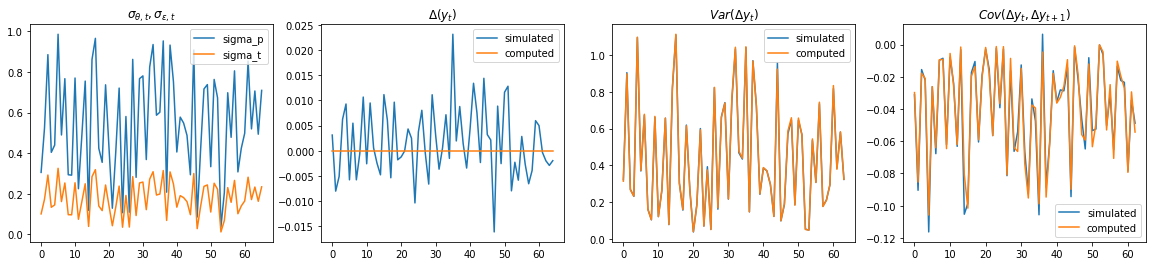

In [6]:
## plot simulated moments of first diff 

plt.figure(figsize=((20,4)))

plt.subplot(1,4,1)
plt.title(r'$\sigma_{\theta,t},\sigma_{\epsilon,t}$')
plt.plot(p_sigmas_draw,label='sigma_p')
plt.plot(t_sigmas,label='sigma_t')
plt.legend(loc=0)

plt.subplot(1,4,2)
plt.title(r'$\Delta(y_t)$')
plt.plot(av,label='simulated')
plt.plot(av_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,3)
plt.title(r'$Var(\Delta y_t)$')
plt.plot(var,label='simulated')
plt.plot(var_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,4)
plt.title(r'$Cov(\Delta y_t,\Delta y_{t+1})$')
plt.plot(autovarb1,label='simulated')
plt.plot(autovarb1_comp,label='computed')
plt.legend(loc = 0)

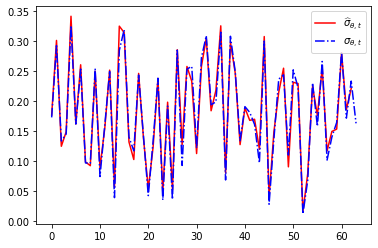

In [7]:
## robustness check if the transitory risks is approximately equal to the assigned level

sigma_t_est = np.array(np.sqrt(abs(autovarb1)))
plt.plot(sigma_t_est,'r-',label=r'$\widehat \sigma_{\theta,t}$')
plt.plot(t_sigmas[1:-1],'b-.',label=r'$\sigma_{\theta,t}$')  # the head and tail trimmed
plt.legend(loc=1)

### Time Aggregation

In [8]:
## time aggregation 

sim_data = dt.SimulateSeries(n_sim = 1000)
dt.n_agg = 3
agg_series = dt.TimeAggregate()
agg_series_moms = dt.SimulateMomentsAgg()

Text(0.5, 1.0, '1-degree autocovariance of different \n level of time aggregation')

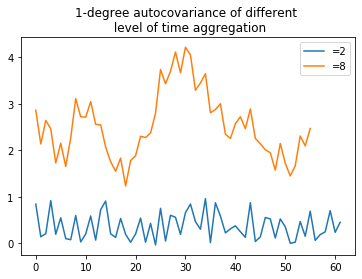

In [9]:
## difference times degree of time aggregation leads to different autocorrelation
for ns in np.array([2,8]):
    an_instance = cp.deepcopy(dt)
    series = an_instance.SimulateSeries(n_sim =500)
    agg_series = an_instance.TimeAggregate(n_periods = ns)
    agg_series_moms = an_instance.SimulateMomentsAgg()
    var_sim = an_instance.AutocovarAgg(step=0)
    var_b1 = an_instance.AutocovarAgg(step=-1)
    plt.plot(var_b1,label=r'={}'.format(ns))
plt.legend(loc=1)
plt.title('1-degree autocovariance of different \n level of time aggregation')

### Estimation

In [10]:
## some fake data moments with alternative parameters

## fix ratio of p and t risks
pt_ratio_fake = 0.66
t_sigmas = pt_ratio_fake * p_sigmas_draw # sizes of the time-varyingpermanent volatility

## both p and t risks are draws
p_sigmas_draw = np.random.uniform(0,1,t)
t_sigmas_draw = np.random.uniform(0,1,t)

sigmas = np.array([p_sigmas_draw,
                   t_sigmas_draw])

dt_fake = ima(t = t,
              ma_coeffs = ma_nosa,
              sigmas = sigmas)
data_fake = dt_fake.SimulateSeries(n_sim = 5000)
moms_fake = dt_fake.SimulatedMoments()

### Estimation using computed moments 

In [11]:
## estimation of income risks 

dt_est = cp.deepcopy(dt)
dt_est.GetDataMoments(moms_fake)

para_guess_this = np.ones(2*t  + dt_est.ma_q)  # make sure the length of the parameters are right 

In [12]:
para_est = dt_est.EstimatePara(method='CG',
                               para_guess = para_guess_this)

Optimization terminated successfully.
         Current function value: 0.901266
         Iterations: 426
         Function evaluations: 86670
         Gradient evaluations: 642


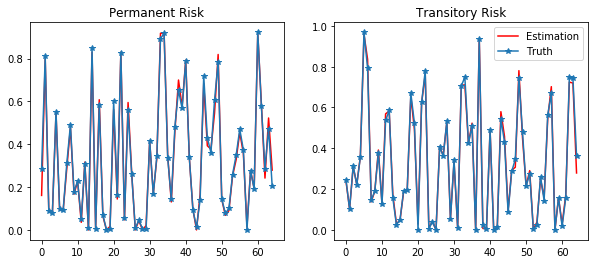

In [13]:
## check the estimation and true parameters 

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est[1][0][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est[1][1][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

In [14]:
### Estimation using computed moments using root finding 

#para_root = dt_est.EstimateParaRoot(para_guess_this)

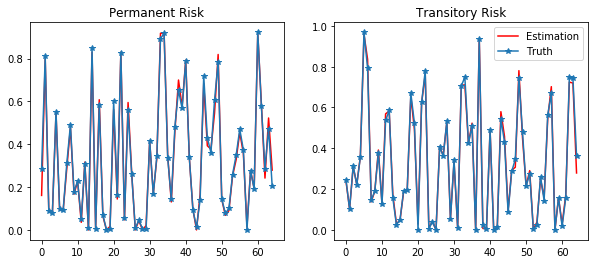

In [15]:

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est[1][0][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est[1][1][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

### Estimation using time aggregated data and computed moments

In [16]:
dt_est.ComputeMomentsAgg(n_agg=2)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.43962123, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 2.08037439, 2.24548401,
        0.39190207],
       [0.        , 0.        , 0.        , ..., 2.24548401, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.39190207, 0.        ,
        0.        ]])

### Estimation using simulated moments 

In [16]:
para_guess_this2 = para_guess_this*0.3

bounds_this = ((0,1),) + ((0,0.5),)*(2*t)

para_est_sim = dt_est.EstimateParabySim(method='CG',
                                        para_guess = para_guess_this2,
                                        options={'disp':True}
                                       )

Optimization terminated successfully.
         Current function value: 5.058719
         Iterations: 31
         Function evaluations: 6885
         Gradient evaluations: 51


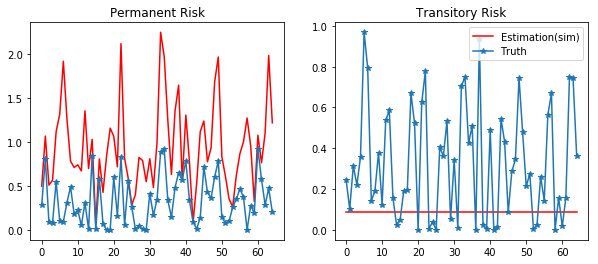

In [17]:
## check the estimation and true parameters

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_sim[1][0][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_sim[1][1][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

In [34]:
### reapeating the estimation for many times

n_loop = 5

para_est_sum_sim = (np.array([0]),np.zeros([2,50]))
for i in range(n_loop):
    para_est_this_time = dt_est.EstimateParabySim(method='CG',
                                                  para_guess = para_guess_this2,
                                                  options = {'disp': True})
    para_est_sum_sim  = para_est_sum_sim + para_est_this_time

Optimization terminated successfully.
         Current function value: 5.994942
         Iterations: 32
         Function evaluations: 8370
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: 5.994942
         Iterations: 32
         Function evaluations: 8370
         Gradient evaluations: 62


KeyboardInterrupt: 

In [31]:
para_est_av = sum([abs(para_est_sum_sim[2*i+1]) for i in range(1,n_loop+1)] )/n_loop

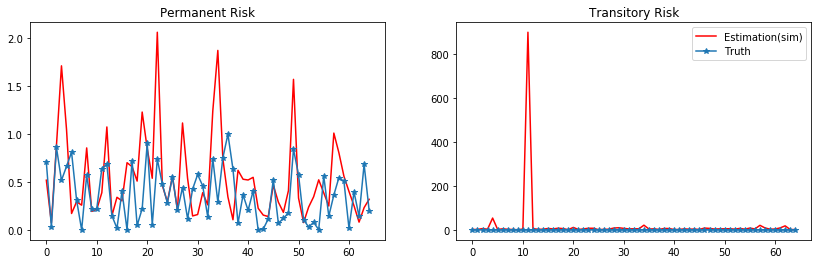

In [32]:
## check the estimation and true parameters

fig = plt.figure(figsize=([14,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(para_est_av[0][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(para_est_av[1][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

#### Estimation using time aggregated data

In [18]:
## get some fake aggregated data moments
moms_agg_fake = dt_fake.TimeAggregate()
moms_agg_dct_fake = dt_fake.SimulateMomentsAgg()

In [19]:
## estimation 
para_guess_this3 = para_guess_this*0.5
dt_est.GetDataMomentsAgg(moms_agg_dct_fake)
dt_est.n_periods = 12
para_est_agg = dt_est.EstimateParaAgg(method ='Powell',
                                      para_guess = para_guess_this3,
                                      options={'disp':True,
                                              'ftol': 0.000000001}
                                     )

Optimization terminated successfully.
         Current function value: 8.499422
         Iterations: 10
         Function evaluations: 16922


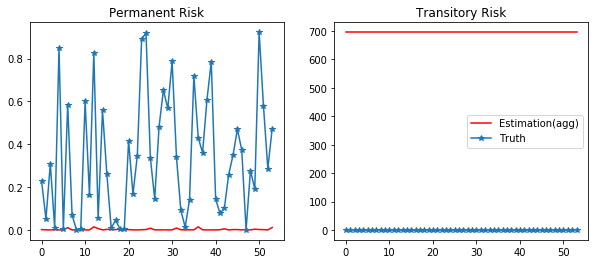

In [20]:
## check the estimation and true parameters

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_agg[1][0][11:-1].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[0][11:-1]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_agg[1][1][11:-1].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[1][11:-1]**2,'-*',label='Truth')
plt.legend(loc=0)

In [31]:
### reapeating the estimation for many times

n_loop = 5

para_est_sum_agg = (np.array([0]),np.zeros([2,50]))
for i in range(n_loop):
    para_est_this_time = dt_est.EstimateParaAgg(method ='Powell',
                                      para_guess = para_guess_this3,
                                      options={'disp':True,
                                              'ftol': 0.000000001})
    para_est_sum_agg = para_est_sum_agg + para_est_this_time

Optimization terminated successfully.
         Current function value: 98.225769
         Iterations: 2
         Function evaluations: 3857
Optimization terminated successfully.
         Current function value: 73.543673
         Iterations: 2
         Function evaluations: 4073
Optimization terminated successfully.
         Current function value: 18.826750
         Iterations: 5
         Function evaluations: 9963
Optimization terminated successfully.
         Current function value: 35.932370
         Iterations: 3
         Function evaluations: 6034
Optimization terminated successfully.
         Current function value: 41.160822
         Iterations: 3
         Function evaluations: 6286


In [32]:
para_est_av_agg = sum([abs(para_est_sum_agg[2*i+1]) for i in range(1,n_loop+1)] )/n_loop

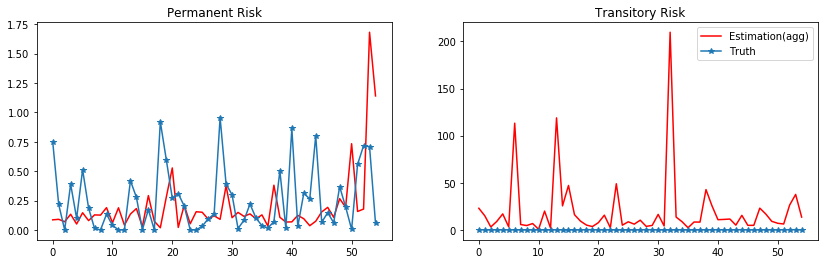

In [36]:
## check the estimation and true parameters

fig = plt.figure(figsize=([14,4]))


plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(para_est_av_agg[0][11:].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[0][11:]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(para_est_av_agg[1][11:].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[1][11:]**2,'-*',label='Truth')
plt.legend(loc=0)